## Imports

In [1]:
import os
import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from keras.models import Sequential # type: ignore
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D, TimeDistributed # type: ignore
from keras.optimizers import Nadam # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from keras.utils import to_categorical # type: ignore
from keras.regularizers import l2 # type: ignore
from sklearn.utils import shuffle # type: ignore

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Constants

In [2]:
DOWNSAMPLING_STEP = 4
NUM_CLASSES = 4

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

## Load data

In [3]:
def get_dataset_name(filename_with_dir):
    filename_without_dir = str(filename_with_dir.name)
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = '_'.join(temp)
    # chunk_n = filename_without_dir.split('_').split('.')[0]
    return dataset_name


def extract_label(filename, logs=False, encode_mapping=ENCODE_MAP):
    if 'rest' in filename:
        print(f'Mapping label {filename} to {encode_mapping["rest"]}') if logs else None
        return encode_mapping['rest']
    elif 'motor' in filename:
        print(f'Mapping label {filename} to {encode_mapping["motor"]}') if logs else None
        return encode_mapping['motor']
    elif 'memory' in filename:
        print(f'Mapping label {filename} to {encode_mapping["memory"]}') if logs else None
        return encode_mapping['memory']
    else:
        print(f'Mapping label {filename} to {encode_mapping["math"]}') if logs else None
        return encode_mapping['math']


def load_all_data(folder_path, logs=False, batch_size=100):
    folder_path = Path(folder_path)
    X = []
    y = []

    for filename in os.listdir(folder_path):
        # current_chunk
        if filename.endswith('.h5'):
            print(f"Loading {filename}...") if logs else None
            file_path = folder_path / filename
            with h5py.File(file_path, 'r') as f:
                dataset_name = get_dataset_name(file_path)
                data = f.get(dataset_name)[()]
                data = data.T

                num_batches = len(data) // batch_size
                data_batches = np.split(data[:num_batches * batch_size], num_batches)
                print(len(data_batches))

                label = extract_label(filename)
                print(f"Data shape: {data.shape}, label: {label}") if logs else None

                X += data_batches
                # X.append(data)       # shape (248, 35624)
                y += [label]*num_batches

    X = np.array(X)  # shape (n_samples, 248, 35624)
    print(X.shape)
    y = np.array(y)  # shape (n_samples,)
    print(y.shape)
    return X, y

## Preprocessing

In [4]:
def z_score_normalize(data):
    # data: shape (248,)
    mean = np.mean(data)
    std = np.std(data) + 1e-8
    return (data - mean) / std

def downsample(data, step=DOWNSAMPLING_STEP):
    # data: shape (248,)
    return data[::step]


In [6]:
# Specify the folder name and load the data. (Don't push data folders to GitHub!!!)
X_train, y_train = load_all_data("Intra/train", logs=1)

Loading rest_105923_8.h5...
356
Data shape: (35624, 248), label: 0
Loading task_story_math_105923_4.h5...
356
Data shape: (35624, 248), label: 3
Loading task_motor_105923_8.h5...
356
Data shape: (35624, 248), label: 1
Loading task_story_math_105923_1.h5...
356
Data shape: (35624, 248), label: 3
Loading task_story_math_105923_5.h5...
356
Data shape: (35624, 248), label: 3
Loading task_working_memory_105923_5.h5...
356
Data shape: (35624, 248), label: 2
Loading task_motor_105923_7.h5...
356
Data shape: (35624, 248), label: 1
Loading rest_105923_2.h5...
356
Data shape: (35624, 248), label: 0
Loading rest_105923_6.h5...
356
Data shape: (35624, 248), label: 0
Loading task_working_memory_105923_1.h5...
356
Data shape: (35624, 248), label: 2
Loading task_motor_105923_3.h5...
356
Data shape: (35624, 248), label: 1
Loading rest_105923_7.h5...
356
Data shape: (35624, 248), label: 0
Loading task_motor_105923_2.h5...
356
Data shape: (35624, 248), label: 1
Loading task_working_memory_105923_4.h5...

In [ ]:
print(X_train.shape)
print(y_train.shape)

(11392, 100, 248)
(11392,)


In [7]:
print(f"X_train shape before preprocessing {np.array(X_train).shape}")  # 3D array: (n_samples, n_channels, n_times)
X_train = z_score_normalize(X_train) # TODO DOWNSAMPLE
X_train = np.array(X_train)  # shape (n_samples, n_channels, n_times)
# X_train = np.transpose(X_train, (0, 2, 1))

# perm = np.random.permutation(len(X_train))
# X_train = X_train[perm]
# y_train = y_train[perm]
X_train, y_train = shuffle(X_train, y_train)


print(f"X_train shape after preprocessing {np.array(X_train).shape}")  # 3D array: (n_samples, n_channels, n_times)


X_train shape before preprocessing (11392, 100, 248)
X_train shape after preprocessing (11392, 100, 248)


In [8]:
y_train

array([1, 1, 1, ..., 2, 1, 1])

## LSTM Model only

In [116]:

time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define LSTM model
lstm_model = Sequential([
    TimeDistributed(Dense(128, kernel_regularizer=l2(1e-4)), input_shape=(time_steps, num_channels)),
    
    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),

    LSTM(64, kernel_regularizer=l2(1e-3)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

lstm_model.compile(optimizer=Nadam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


In [117]:
# np.random.shuffle(array)


history = lstm_model.fit(
    X_train, y_train,   
    epochs=3,
    batch_size=20,
    validation_split=0.5,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/3
285/285 [==============================] - 45s 136ms/step - loss: 0.6518 - accuracy: 0.8645 - val_loss: 1.4479 - val_accuracy: 0.4224
Epoch 2/3
285/285 [==============================] - 38s 134ms/step - loss: 0.2621 - accuracy: 0.9882 - val_loss: 4.5884 - val_accuracy: 0.2449
Epoch 3/3
285/285 [==============================] - 39s 137ms/step - loss: 0.2065 - accuracy: 0.9925 - val_loss: 1.7868 - val_accuracy: 0.7514


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# One-hot encode if needed
if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

# Split manually (50% validation)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42, stratify=y_train.argmax(axis=1))

# Model definition
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lstm_model = Sequential([
    Conv1D(64, kernel_size=1, activation='linear', input_shape=(time_steps, num_channels)),
    
    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(64, kernel_regularizer=l2(1e-3)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.4),

    Dense(NUM_CLASSES, activation='softmax')
])


lstm_model.compile(
    optimizer=Nadam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = lstm_model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.1660 - loss: 1.8674 - val_accuracy: 0.2474 - val_loss: 1.6341
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.1945 - loss: 1.7887 - val_accuracy: 0.2502 - val_loss: 1.6335
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.2441 - loss: 1.7213 - val_accuracy: 0.2732 - val_loss: 1.6203
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.2845 - loss: 1.6429 - val_accuracy: 0.3685 - val_loss: 1.5610
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.3324 - loss: 1.5946 - val_accuracy: 0.5063 - val_loss: 1.4799
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.3738 - loss: 1.5403 - val_accuracy: 0.6601 - val_loss: 1.4149
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.4135 - loss: 1.4914 - val_accuracy: 0.6898 - val_loss: 1.3653
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.4621 - loss: 1.4420 - 

## Testing and evaluating part

In [10]:
# Load and preprocess test data
X_test, y_test = load_all_data("Data/Intra/test", logs=0)
print(f"X_test shape before preprocessing: {np.array(X_test).shape}")

X_test = z_score_normalize(X_test) # TODO DOWNSAMPLE

X_test = np.array(X_test)
print(f"X_test shape after preprocessing: {np.array(X_test).shape}")

# One-hot encode labels
y_test = to_categorical(y_test, num_classes=4)

356
356
356
356
356
356
356
356
(2848, 100, 248)
(2848,)
X_test shape before preprocessing: (2848, 100, 248)
X_test shape after preprocessing: (2848, 100, 248)


In [22]:
# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

89/89 [==============================] - 3s 33ms/step - loss: 0.7820 - accuracy: 0.9996
Test accuracy: 0.9996488690376282


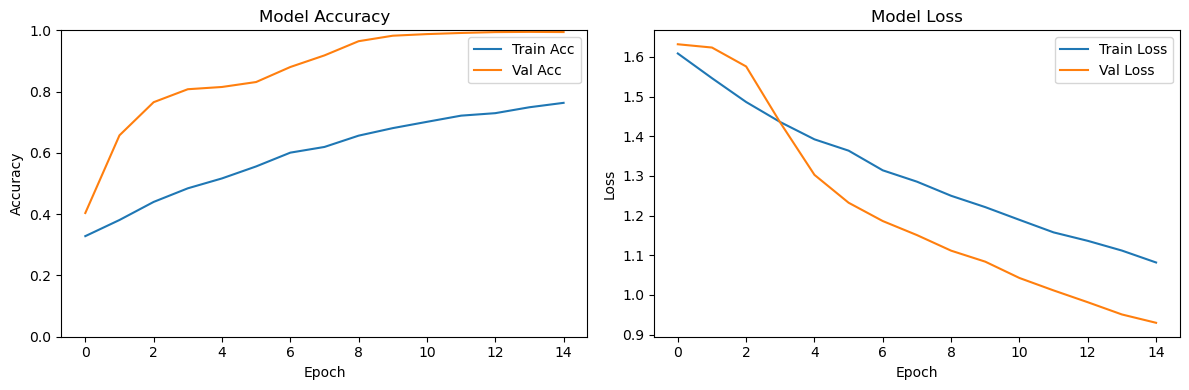

In [23]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


89/89 [==============================] - 3s 28ms/step


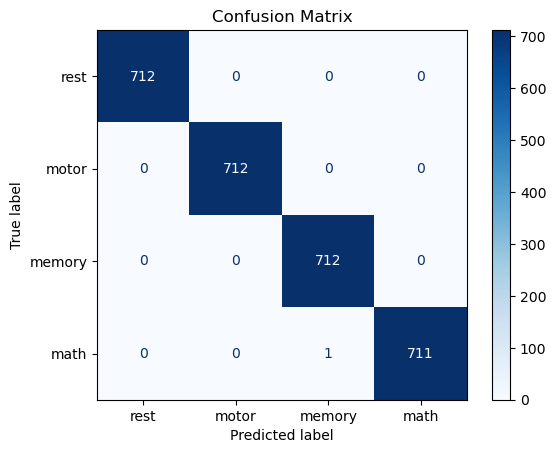

In [24]:
# Predict class probabilities
y_pred_probs = lstm_model.predict(X_test)
# Convert one-hot back to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Cross

In [14]:
# Load and preprocess test data
X_test_cross, y_test_cross = load_all_data("Data/Cross/test1/", logs=0)
print(f"X_test shape before preprocessing: {np.array(X_test_cross).shape}")

X_test_cross = z_score_normalize(X_test_cross) # TODO DOWNSAMPLE

X_test_cross = np.array(X_test_cross)
print(f"X_test_cross shape after preprocessing: {np.array(X_test_cross).shape}")

# One-hot encode labels
y_test_cross = to_categorical(y_test_cross, num_classes=4)

356
356
356
356
356
356
356
356
356
356
356
356
356
356
356
356
(5696, 100, 248)
(5696,)
X_test shape before preprocessing: (5696, 100, 248)
X_test_cross shape after preprocessing: (5696, 100, 248)


In [25]:
# Evaluate
test_loss_cross, test_acc_cross = lstm_model.evaluate(X_test_cross, y_test_cross, verbose=1)
print("Test accuracy:", test_acc_cross)

178/178 [==============================] - 8s 43ms/step - loss: 1.3248 - accuracy: 0.4709
Test accuracy: 0.47085675597190857
